In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV

from xgboost import XGBClassifier
import random
from scipy.stats import uniform, randint

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


In [2]:
df_train = pd.read_csv('./final_trainset.csv')
df_test = pd.read_csv('./final_testset.csv')

In [3]:
# split dataset
X = {}
y = {}

X['train'] = df_train.iloc[:, :-1]
y['train'] = df_train.benh21

X['test'] = df_test.iloc[:, :-1]
y['test'] = df_test.benh21

In [4]:
# parameter
p_folds = 20
p_iter = 1000
p_estimators = 1000
p_learning_rate = 0.00001

# XGBoost
params = {
        'max_depth': randint(5, 10),
        'gamma': uniform(0.0, 0.5),
        'subsample': uniform(0.6, 1.0),
        'colsample_bytree': uniform(0.6, 1.0),
        'reg_alpha': uniform(0.0, 1.0),
        'reg_lambda': uniform(0.0, 1.0),
        'min_child_weight': randint(3, 7),
        'scale_pos_weight': randint(1, 10)
        }

In [5]:
xgb = XGBClassifier(learning_rate=p_learning_rate, n_estimators=p_estimators, objective='binary:logistic')

In [6]:
folds = p_folds
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
model_xgb = RandomizedSearchCV(xgb, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X['train'], y['train']), verbose=-1, random_state=1001)
model_xgb.fit(X['train'], y['train'])

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x79e1271911c0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79e1271b6020>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79e1271b5e10>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79e1271b6bc0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79e1271b7be0>},
                   random_state=1001, scoring='roc_auc', verbose=-1)

In [7]:
print(model_xgb.best_estimator_)
print(model_xgb.best_params_)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6213861274463689, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4868988425820678,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1e-05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
{'colsample_bytree': 0.6213861274463689, 'gamma': 0.4868988425820678, 'max_depth': 8, 'min_child_weight': 3, 'reg_alpha': 0.5924661893762875, 'reg_lambda': 0.06338785318074813, 'scale_pos_weight': 1, 'subs

In [8]:
model_xgb.best_estimator_.save_model('xgboost_model_state.json')

In [9]:
best_xgb =XGBClassifier(**model_xgb.best_estimator_.get_params())
best_xgb.fit(X['train'],y['train'])
acc = best_xgb.score(X['test'], y['test'])
print('Accuracy of XGBoost : {}'.format(acc))

Accuracy of XGBoost : 0.7095070422535211


In [10]:
xgb_pred_test = model_xgb.predict(X['test'])
xgb_proba_test = model_xgb.predict_proba(X['test'])[:,1]

Scoring Metrics for RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x79e1271911c0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79e1271b6020>,
                                        'reg_lambda': <scipy.stats

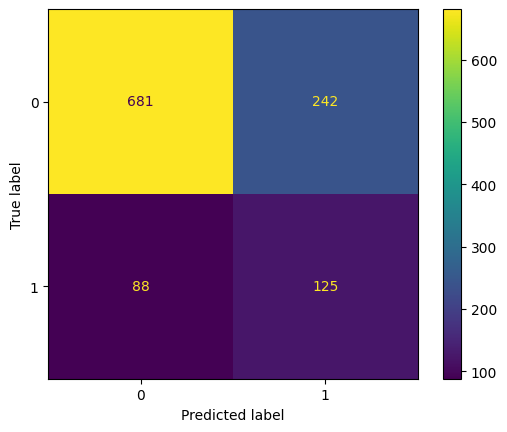

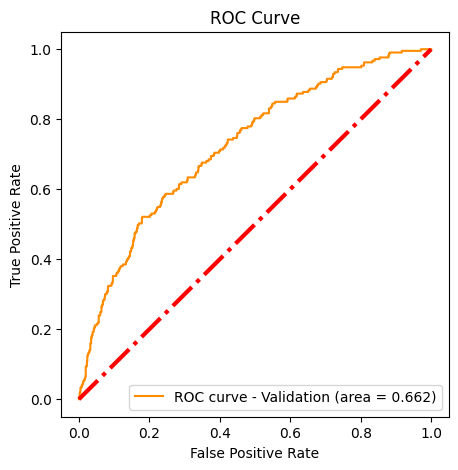

In [11]:
test_predict = pd.DataFrame(xgb_pred_test)

print('Scoring Metrics for {} (Validation):'.format(model_xgb))
print('Balanced Accuracy Score = {:.5f}'.format(metrics.balanced_accuracy_score(y['test'], test_predict)))
print('Accuracy Score = {:.5f}'.format(metrics.accuracy_score(y['test'], test_predict)))
print('Precision Score = {:.5f}'.format(metrics.precision_score(y['test'], test_predict)))
print('Recall Score = {:.5f}'.format(metrics.recall_score(y['test'], test_predict, labels=['0','1'])))
print('F1 Score = {:.5f}'.format(metrics.f1_score(y['test'], test_predict, labels=['0','1'])))
print('ROC AUC Score = {:.5f}'.format(metrics.roc_auc_score(y['test'], test_predict, labels=['0','1'])))

print('Confusion Matrix:')
print(metrics.confusion_matrix(y['test'], test_predict))

print("Classification_report")
print(metrics.classification_report(y['test'], test_predict, target_names=['0','1']))
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y['test'], test_predict)).plot()

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y['test'], xgb_proba_test )

roc_auc = metrics.roc_auc_score(y['test'], test_predict, labels=['0','1'])

# Precision x Recall Curve
precision, recall, thresholds = metrics.precision_recall_curve(y['test'], xgb_proba_test )

print('ROC Curve:')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve - Validation (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='-.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()